In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D
from PIL import Image
import functions
from GP import GP
import time
import imageio

In [2]:
Noise = True # Specify if noisy or not
Noise_level = 0.1 # if noisy, what is the noise sd
'''If use the scaled X and Y, rememeber to scale the noise as well'''

'If use the scaled X and Y, rememeber to scale the noise as well'

In [3]:
# objective = functions.sincos(Noise, Noise_level)
objective = functions.sin(Noise, Noise_level)

bounds = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float)
print(bounds) 

f = objective.func
print(f( np.array([2, 1]) ))
# np.sin(np.array([2, 1]))

dim = objective.input_dim
print('dim: ', dim)

[[-1. 15.]]
[[1.08570266]
 [0.88148671]]
dim:  1


In [4]:
# max budget for finding good point
Budget = 100
# set seed
seed = 0
# Acq_names=['PI','PG','EI','EG','gp_ucb','random','TS','SATS','G_ES','MES']
acquation_function = 'random'

In [5]:
def draw(n_random_draws=3):
    """ samples some points"""
    np.random.seed(seed)
    X = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_random_draws, dim))
    return X, f(X)

gp = GP(bounds, Noise, Noise_level)

def get_kernel(sample_size=200):
    np.random.seed(seed)
    X = np.asarray(np.random.uniform(bounds[:, 0], bounds[:, 1], size=(sample_size, dim)))
    gp.set_data(X, f(X))
    # gp.optimize()
    gp.fit()
    return gp.get_hyper()

In [6]:
get_kernel()
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1, dim)
mu, covar = gp.posterior(Xtest)
s = np.sqrt(np.diag(covar))
mu = np.squeeze(mu)

# for prior
K_ = gp.cov_RBF(Xtest, Xtest, gp.get_hyper())
K_

(200, 200)
(200, 1)


array([[1.00000000e+00, 9.79390679e-01, 9.20076348e-01, ...,
        1.05130882e-20, 1.45394220e-21, 1.92874985e-22],
       [9.79390679e-01, 1.00000000e+00, 9.79390679e-01, ...,
        7.29164325e-20, 1.05130882e-20, 1.45394220e-21],
       [9.20076348e-01, 9.79390679e-01, 1.00000000e+00, ...,
        4.85101310e-19, 7.29164325e-20, 1.05130882e-20],
       ...,
       [1.05130882e-20, 7.29164325e-20, 4.85101310e-19, ...,
        1.00000000e+00, 9.79390679e-01, 9.20076348e-01],
       [1.45394220e-21, 1.05130882e-20, 7.29164325e-20, ...,
        9.79390679e-01, 1.00000000e+00, 9.79390679e-01],
       [1.92874985e-22, 1.45394220e-21, 1.05130882e-20, ...,
        9.20076348e-01, 9.79390679e-01, 1.00000000e+00]])

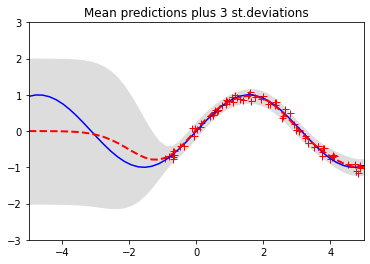

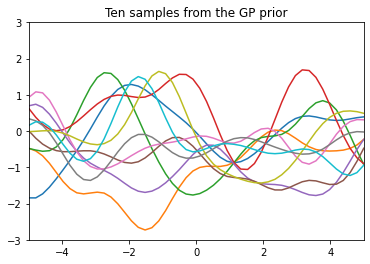

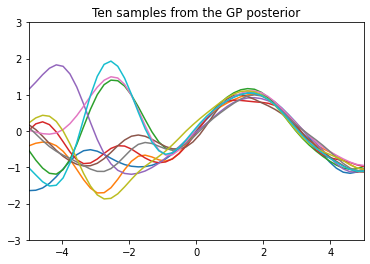

In [8]:
# plot

X = np.squeeze(gp.X)
y = np.squeeze(gp.y)

Xtest = np.squeeze(Xtest)

pl.figure(1)
pl.clf()
pl.plot(X, y, 'r+', ms=7)
pl.plot(Xtest, np.sin(Xtest), 'b-')
pl.gca().fill_between(Xtest.flat, mu-2*s, mu+2*s, color="#dddddd")

pl.plot(Xtest, mu, 'r--', lw=2)
pl.savefig('predictive.png', bbox_inches='tight')
pl.title('Mean predictions plus 3 st.deviations')
pl.axis([-5, 5, -3, 3])

# draw samples from the prior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n))
f_prior = np.dot(L, np.random.normal(size=(n,10)))
pl.figure(2)
pl.clf()
pl.plot(Xtest, f_prior)
pl.title('Ten samples from the GP prior')
pl.axis([-5, 5, -3, 3])
# pl.savefig('prior.png', bbox_inches='tight')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(covar + 1e-6*np.eye(n)) # LL^T = Sigma (posterior covariance)
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n, 10)))
pl.figure(3)
pl.clf()
pl.plot(Xtest, f_post)
pl.title('Ten samples from the GP posterior')
pl.axis([-5, 5, -3, 3])
pl.savefig('post.png', bbox_inches='tight')

pl.show()